<a href="https://colab.research.google.com/github/100rab-S/Tensorflow-Developer-Certificate/blob/main/S%2BP_Week_4_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-04-30 12:08:22--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2021-04-30 12:08:22 (5.00 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



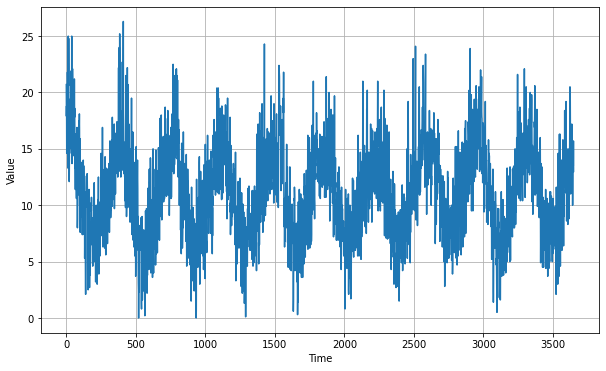

In [5]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step += 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# window_size = 30
# batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 33s 58ms/step - loss: 31.0287 - mae: 31.5267
Epoch 2/100
10/10 [==============================] - 1s 61ms/step - loss: 30.7622 - mae: 31.2600
Epoch 3/100
10/10 [==============================] - 1s 64ms/step - loss: 29.8503 - mae: 30.3478
Epoch 4/100
10/10 [==============================] - 1s 61ms/step - loss: 28.3606 - mae: 28.8579
Epoch 5/100
10/10 [==============================] - 1s 64ms/step - loss: 26.4927 - mae: 26.9895
Epoch 6/100
10/10 [==============================] - 1s 62ms/step - loss: 23.9679 - mae: 24.4643
Epoch 7/100
10/10 [==============================] - 1s 57ms/step - loss: 20.4446 - mae: 20.9406
Epoch 8/100
10/10 [==============================] - 1s 61ms/step - loss: 15.0687 - mae: 15.5620
Epoch 9/100
10/10 [==============================] - 1s 59ms/step - loss: 9.4945 - mae: 9.9814
Epoch 10/100
10/10 [======

(1e-08, 0.01, 0.0, 60.0)

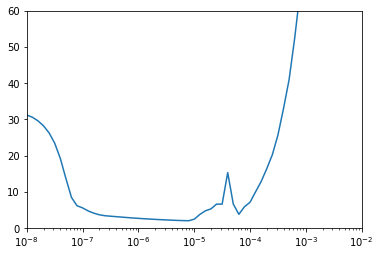

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 60])

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 20
batch_size = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters = 60, kernel_size=3, padding = 'same', activation='relu'),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(120, activation = 'relu'),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=30)

Epoch 1/30
25/25 [==============================] - 5s 20ms/step - loss: 10.8756 - mae: 11.3665
Epoch 2/30
25/25 [==============================] - 1s 19ms/step - loss: 2.9964 - mae: 3.4650
Epoch 3/30
25/25 [==============================] - 1s 21ms/step - loss: 1.8425 - mae: 2.2930
Epoch 4/30
25/25 [==============================] - 1s 21ms/step - loss: 1.5059 - mae: 1.9466
Epoch 5/30
25/25 [==============================] - 1s 21ms/step - loss: 1.2796 - mae: 1.7099
Epoch 6/30
25/25 [==============================] - 1s 22ms/step - loss: 1.1525 - mae: 1.5757
Epoch 7/30
25/25 [==============================] - 1s 26ms/step - loss: 1.0909 - mae: 1.5091
Epoch 8/30
25/25 [==============================] - 1s 23ms/step - loss: 1.0445 - mae: 1.4590
Epoch 9/30
25/25 [==============================] - 1s 24ms/step - loss: 0.9767 - mae: 1.3854
Epoch 10/30
25/25 [==============================] - 1s 24ms/step - loss: 0.9324 - mae: 1.3365
Epoch 11/30
25/25 [==============================] - 1s 2

In [32]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

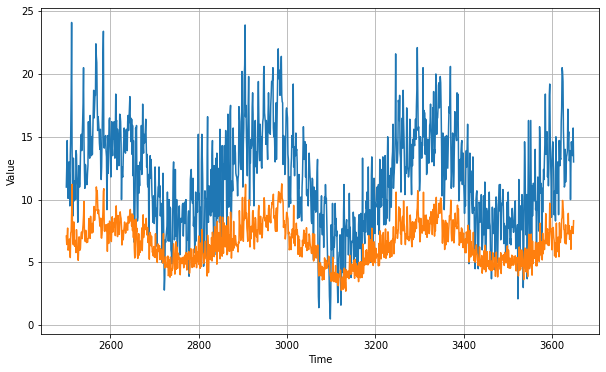

In [33]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [34]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.18546

In [36]:
print(rnn_forecast)

[7.0958867 6.425783  7.1336045 ... 7.3726068 7.303001  8.320693 ]
